# Preliminaries

In this section, we gather the code provided to us.

In [1]:
# %load mlmc.py
import numpy as np
import numpy.linalg
import numpy.random as rd
import timeit
import sys
from math import sqrt
import matplotlib.pyplot as plt

class WeakConvergenceFailure(Exception):
    pass

def mlmc(Lmin, Lmax, N0, eps, mlmc_fn, alpha_0, beta_0, gamma):
    """
    Multi-level Monte Carlo estimation.

    (P, Nl) = mlmc(...)

    Outputs:
      P:  value
      Nl: number of samples on each level
    Inputs:
      Lmin: minimum level of refinement  >= 2
      Lmax: maximum level of refinement  >= Lmin
      N0:   initial number of samples    >  0
      eps:  desired accuracy (rms error) >  0

      alpha: weak error is  O(2^{-alpha*l})
      beta:  variance is    O(2^{-beta*l})
      gamma: sample cost is O(2^{gamma*l})  > 0

      If alpha, beta are not positive then they will be estimated.

      mlmc_fn: the user low-level routine. Its interface is
        sums = mlmc_fn(l, N)
      with inputs
        l = level
        N = number of paths
      and a numpy array of outputs
        sums[0] = sum(Y)
        sums[1] = sum(Y**2)
      where Y are iid samples with expected value
        E[P_0]            on level 0
        E[P_l - P_{l-1}]  on level l > 0
    """

    # Check arguments

    if Lmin < 2:
        raise ValueError("Need Lmin >= 2")
    if Lmax < Lmin:
        raise ValueError("Need Lmax >= Lmin")
    if N0 <= 0 or eps <= 0 or gamma <= 0:
        raise ValueError("Need N0 > 0, eps > 0, gamma > 0")

    # Initialisation

    alpha = max(0, alpha_0)
    beta  = max(0, beta_0)

    theta = 0.25

    L = Lmin

    Nl   = numpy.zeros(L+1)
    suml = numpy.zeros((2, L+1))
    dNl  = N0*numpy.ones(L+1)

    while sum(dNl) > 0:

        # update sample sums

        for l in range(0, L+1):
            if dNl[l] > 0:
                sums       = mlmc_fn(l, int(dNl[l]))
                Nl[l]      = Nl[l] + dNl[l]
                suml[0, l] = suml[0, l] + sums[0]
                suml[1, l] = suml[1, l] + sums[1]

        # compute absolute average and variance

        ml = numpy.abs(       suml[0, :]/Nl)
        Vl = numpy.maximum(0, suml[1, :]/Nl - ml**2)

        # fix to cope with possible zero values for ml and Vl
        # (can happen in some applications when there are few samples)

        for l in range(3, L+2):
            ml[l-1] = max(ml[l-1], 0.5*ml[l-2]/2**alpha)
            Vl[l-1] = max(Vl[l-1], 0.5*Vl[l-2]/2**beta)

        # use linear regression to estimate alpha, beta if not given
        if alpha_0 <= 0:
            A = numpy.ones((L, 2)); A[:, 0] = range(1, L+1)
            x = numpy.linalg.solve(A, numpy.log2(ml[1:]))
            alpha = max(0.5, -x[0])

        if beta_0 <= 0:
            A = numpy.ones((L, 2)); A[:, 0] = range(1, L+1)
            x = numpy.linalg.solve(A, numpy.log2(Vl[1:]))
            beta = max(0.5, -x[0])

        # set optimal number of additional samples

        Cl = 2**(gamma*numpy.arange(0, L+1))
        Ns = numpy.ceil( numpy.sqrt(Vl/Cl) * sum(numpy.sqrt(Vl*Cl)) / ((1-theta)*eps**2) )
        dNl = numpy.maximum(0, Ns-Nl)

        # if (almost) converged, estimate remaining error and decide
        # whether a new level is required

        if sum(dNl > 0.01*Nl) == 0:
            rem = ml[L] / (2.0**alpha - 1.0)

            if rem > numpy.sqrt(theta)*eps:
                if L == Lmax:
                    raise WeakConvergenceFailure("Failed to achieve weak convergence")
                else:
                    L = L + 1
                    Vl = numpy.append(Vl, Vl[-1] / 2.0**beta)
                    Nl = numpy.append(Nl, 0.0)
                    suml = numpy.column_stack([suml, [0, 0]])

                    Cl = 2**(gamma*numpy.arange(0, L+1))
                    Ns = numpy.ceil( numpy.sqrt(Vl/Cl) * sum(numpy.sqrt(Vl*Cl)) / ((1-theta)*eps**2) )
                    dNl = numpy.maximum(0, Ns-Nl)

    # finally, evaluate the multilevel estimator
    P = sum(suml[0,:]/Nl)

    return (P, Nl)


def mlmc_test(mlmc_fn, M, N, L, N0, Eps, Lmin, Lmax, logfile):
    """
    Multilevel Monte Carlo test routine.

    mlmc_fn: the user low-level routine. Its interface is
      sums = mlmc_fn(l, N)
    with inputs
      l = level
      N = number of paths
    and a numpy array of outputs
      sums[0] = sum(Pf-Pc)
      sums[1] = sum((Pf-Pc)**2)
      sums[2] = sum((Pf-Pc)**3)
      sums[3] = sum((Pf-Pc)**4)
      sums[4] = sum(Pf)
      sums[5] = sum(Pf**2)

    M: refinement cost factor (2**gamma in general MLMC theorem)

    N: number of samples for convergence tests
    L: number of levels for convergence tests

    N0: initial number of samples for MLMC calculations
    Eps: desired accuracy array for MLMC calculations
    """

    # First, convergence tests

    write(logfile, "\n")
    write(logfile, "**********************************************************\n")
    write(logfile, "*** Convergence tests, kurtosis, telescoping sum check ***\n")
    write(logfile, "**********************************************************\n")
    write(logfile, "\n l   ave(Pf-Pc)    ave(Pf)   var(Pf-Pc)    var(Pf)")
    write(logfile, "    kurtosis     check \n-------------------------")
    write(logfile, "--------------------------------------------------\n")

    del1 = []
    del2 = []
    var1 = []
    var2 = []
    kur1 = []
    chk1 = []
    cost = []

    for l in range(0, L+1):
        tic = timeit.default_timer()
        sums = mlmc_fn(l, N)
        toc = timeit.default_timer()
        cost.append(toc - tic)
        sums = sums/N

        if l == 0:
            kurt = 0.0
        else:
            kurt = (     sums[3]
                     - 4*sums[2]*sums[0]
                     + 6*sums[1]*sums[0]**2
                     - 3*sums[0]*sums[0]**3 ) / (sums[1]-sums[0]**2)**2

        del1.append(sums[0])
        del2.append(sums[4])
        var1.append(sums[1]-sums[0]**2)
        var2.append(max(sums[5]-sums[4]**2, 1.0e-10)) # fix for cases with var = 0
        kur1.append(kurt)

        if l == 0:
            check = 0
        else:
            check =          abs(       del1[l]  +      del2[l-1]  -      del2[l])
            check = check / ( 3.0*(sqrt(var1[l]) + sqrt(var2[l-1]) + sqrt(var2[l]) )/sqrt(N))
        chk1.append(check)

        write(logfile, "%2d   %8.4e  %8.4e  %8.4e  %8.4e  %8.4e  %8.4e \n" % \
                      (l, del1[l], del2[l], var1[l], var2[l], kur1[l], chk1[l]))

    if kur1[-1] > 100.0:
        write(logfile, "\n WARNING: kurtosis on finest level = %f \n" % kur1[-1]);
        write(logfile, " indicates MLMC correction dominated by a few rare paths; \n");
        write(logfile, " for information on the connection to variance of sample variances,\n");
        write(logfile, " see http://mathworld.wolfram.com/SampleVarianceDistribution.html\n\n");

    if max(chk1) > 1.0:
        write(logfile, "\n WARNING: maximum consistency error = %f \n" % max(chk1))
        write(logfile, " indicates identity E[Pf-Pc] = E[Pf] - E[Pc] not satisfied \n\n")

    L1 = int(numpy.ceil(0.4*L));
    L2 = L+1;
    pa    = numpy.polyfit(range(L1+1, L2+1), numpy.log2(numpy.abs(del1[L1:L2])), 1);  alpha = -pa[0];
    pb    = numpy.polyfit(range(L1+1, L2+1), numpy.log2(numpy.abs(var1[L1:L2])), 1);  beta  = -pb[0];
    gamma = numpy.log2(cost[-1]/cost[-2]);

    write(logfile, "\n******************************************************\n");
    write(logfile, "*** Linear regression estimates of MLMC parameters ***\n");
    write(logfile, "******************************************************\n");
    write(logfile, "\n alpha = %f  (exponent for MLMC weak convergence)\n" % alpha);
    write(logfile, " beta  = %f  (exponent for MLMC variance) \n" % beta);
    write(logfile, " gamma = %f  (exponent for MLMC cost) \n" % gamma);

    # Second, MLMC complexity tests

    write(logfile, "\n");
    write(logfile, "***************************** \n");
    write(logfile, "*** MLMC complexity tests *** \n");
    write(logfile, "***************************** \n\n");
    write(logfile, "  eps   mlmc_cost   std_cost  savings     N_l \n");
    write(logfile, "----------------------------------------------- \n");

    gamma = numpy.log2(M)
    theta = 0.25

    for eps in Eps:
       (P, Nl) = mlmc(Lmin, Lmax, N0, eps, mlmc_fn, alpha, beta, gamma)
       l = len(Nl) - 1
       mlmc_cost = (1 + 1.0/M)*sum(Nl * M**numpy.arange(0, l+1))
       std_cost  = sum(var2[-1]*M**numpy.arange(0, l+1))/((1.0 -theta)*eps**2)

       write(logfile, "%.4f  %.3e  %.3e  %7.2f " % (eps, mlmc_cost, std_cost, std_cost/mlmc_cost))
       write(logfile, " ".join(["%9d" % n for n in Nl]))
       write(logfile, "\n")

    write(logfile, "\n")

def write(logfile, msg):
    """
    Write to both sys.stdout and to a logfile.
    """
    logfile.write(msg)
    sys.stdout.write(msg)
    
def mlmc_plot(filename, nvert):

    file = open(filename, "r")

    # Declare lists for data
    del1 = []
    del2 = []
    var1 = []
    var2 = []
    kur1 = []
    chk1 = []
    l    = []

    epss = []
    mlmc_cost = []
    std_cost = []
    Ns = []

    for line in file:
        # Recognise convergence test lines from the fact that line[1] is an integer
        if line[0] == ' ' and '0' <= line[1] <= '9':
            splitline = [float(x) for x in line.split()]
            l.append(splitline[0])
            del1.append(splitline[1])
            del2.append(splitline[2])
            var1.append(splitline[3])
            var2.append(splitline[4])
            kur1.append(splitline[5])
            chk1.append(splitline[6])

        # Recognise MLMC complexity test lines from the fact that line[0] is an integer
        if '0' <= line[0] <= '9':
            splitline = [float(x) for x in line.split()]
            epss.append(splitline[0])
            mlmc_cost.append(splitline[1])
            std_cost.append(splitline[2])
            Ns.append(splitline[4:])

    plt.figure(figsize=(8, 6))

    plt.subplot(nvert, 2, 1)
    plt.plot(l,     numpy.log2(var2),     '*-',  label=r'$P_l$')
    plt.plot(l[1:], numpy.log2(var1[1:]), '*--', label=r'$P_l - P_{l-1}$')
    plt.xlabel('level $l$')
    plt.ylabel(r'$\mathrm{log}_2(\mathrm{variance})$')
    plt.legend(loc='lower left', fontsize='x-small')

    plt.subplot(nvert, 2, 2)
    plt.plot(l,     numpy.log2(numpy.abs(del2)),     '*-',  label=r'$P_l$')
    plt.plot(l[1:], numpy.log2(numpy.abs(del1[1:])), '*--', label=r'$P_l - P_{l-1}$')
    plt.xlabel('level $l$')
    plt.ylabel(r'$\mathrm{log}_2(|\mathrm{mean}|)$')
    plt.legend(loc='lower left', fontsize='x-small')

    if nvert == 3:
        plt.subplot(nvert, 2, 3)
        plt.plot(l[1:], chk1[1:], '*--')
        plt.xlabel('level $l$')
        plt.ylabel(r'consistency check')
        axis = plt.axis(); plt.axis([0, max(l), axis[2], axis[3]])

        plt.subplot(nvert, 2, 4)
        plt.plot(l[1:], kur1[1:], '*--')
        plt.xlabel('level $l$')
        plt.ylabel(r'kurtosis')
        axis = plt.axis(); plt.axis([0, max(l), axis[2], axis[3]])

    styles = ['o--', 'x--', 'd--', '*--', 's--']
    plt.subplot(nvert, 2, 2*nvert-1)
    for (eps, N, style) in zip(epss, Ns, styles):
        plt.semilogy(N, style, label=eps)
    plt.xlabel('level $l$')
    plt.ylabel('$N_l$')
    plt.legend(loc='upper right', frameon=True, fontsize='x-small')

    eps = numpy.array(epss)
    std_cost = numpy.array(std_cost)
    mlmc_cost = numpy.array(mlmc_cost)
    plt.subplot(nvert, 2, 2*nvert)
    plt.loglog(eps, eps**2 * std_cost,  '*-',  label='std MC')
    plt.loglog(eps, eps**2 * mlmc_cost, '*--', label='MLMC')
    plt.xlabel(r'accuracy $\epsilon$')
    plt.ylabel(r'$\epsilon^2$ cost')
    plt.legend(fontsize='x-small')
    axis = plt.axis(); plt.axis([min(eps), max(eps), axis[2], axis[3]])

    plt.subplots_adjust(wspace=0.3)

# Code

Our SDE 
\begin{align*}
dX_t = -X_tdt + dW_t
\end{align*}
with initial condition $X_0 = 0$ has explicit solution
\begin{align*}
X_t = \exp(-t)\int_0^t \exp(s)dW_s.
\end{align*}
Thus
\begin{align}
\label{eq1}
X_t \sim \mathcal{N} \left( 0, \frac{1}{2}\left(1- \exp(-2t) \right) \right).
\end{align}
We wish to implement a multilevel Monte Carlo estimator of $\lim_{t \rightarrow \infty} \mathbb{E}\left[ X_t^2 \right]$. The theoretical value is easily deduced from \eqref{eq1} to be $1/2$. The scheme implemented is based on slides 7 and 8 in lecture 15. From the p.d.f.s of \eqref{eq1} and a $\mathcal{N}(0,1/2)$ r.v. we deduce that $\lambda_1 =2$. This is easily seen by changing scale from $t$ to $x = \exp(-2t)$ and expanding the p.d.f. of \eqref{eq1} about $x = 0$ (which corresponds to $t = \infty$). The first term in the expansion will be precisely the p.d.f. of a $\mathcal{N}(0,1/2)$ r.v. and subsequent terms will be $\mathcal{O}(\exp(-2t))$, $\mathcal{O}(\exp(-4t))$, $\mathcal{O}(\exp(-6t))$ etc. This motivates the choice of 
\begin{align}
h_\ell &= \frac{1}{n_0} M^{-\ell} & T_{\ell} = (\ell+1)\frac{\log(M)}{2}
\end{align}
where $n_0 \in \mathbb{Z}_+$ is an initial number of time steps and $M \in \mathbb{Z}_+$  is a refinement factor.

In [13]:
def sde_mlmc(n0, M, N, l):
    """
    n0: number of steps in layer 0
    M: refinement factor
    N: total number of paths to use
    l: level for MLMC
    
    return sums, an array with 6 entries, 
    sums[0] is the sum of estimators of the difference,
    sums[1] is the sum of square estimators of the difference, 
    sums[2] is the sum of cubic estimators of the difference,
    sums[3] is the sum of quartic estimators of the difference,
    sums[4] is the sum of estimators at the fine level,
    sums[5] is the sum of square estimators at the fine level,
    
    """
    
    T_new = (l+1) * np.log(M) / 2
    T_old = l * np.log(M) / 2
    T_delta = T_new - T_old

    nf = n0 * (M ** l)
    hf = 1 / nf
    cf = T_new / hf

    nc = nf/M
    hc = 1 / nc
    cc = T_old / hc

    cd = T_delta / hf
    
    sums = numpy.zeros(6)

    for N1 in range(1, N+1, 10000):
        N2 = min(10000, N - N1 + 1)

        Xc = np.zeros(N2)
        Xf = np.zeros(N2)

        if l == 0:
            for n in range(int(cf)):
                dWf = sqrt(hf) * rd.randn(1, N2)
                Xf = (1 - hf)*Xf + dWf
            
        else:
             
            for z in range(int(cd)):
                dWf = sqrt(hf) * rd.randn(1, N2)
                Xf = (1 - hf)*Xf + dWf  
                
            for n in range(int(cc)):
                dWc = np.zeros((1, N2))

                for m in range(M):
                    dWf = sqrt(hf) * rd.randn(1, N2)
                    dWc = dWc + dWf
                    Xf = (1  - hf)*Xf + dWf

                Xc = (1  - hc)*Xc + dWc
 
        Pf = Xf ** 2
        Pc = Xc ** 2

        sums += np.array([np.sum(Pf - Pc),
                             np.sum((Pf - Pc)**2),
                             np.sum((Pf - Pc)**3),
                             np.sum((Pf - Pc)**4),
                             np.sum(Pf),
                             np.sum(Pf**2)])
    return numpy.array(sums)

We can now run the \textit{mlmc_test} code with target accuracies $\epsilon = 0.05,0.02,0.01,0.005, 0.002, 0.001$.

In [14]:
filename = "file%d.txt"
logfile = open(filename, "w")

M   = 2 #re-finement factor.
N   = 20000 #number of samples for convergence tests
L   = 5 #number of levels for convergence tests
Eps = [0.05, 0.02, 0.01, 0.005, 0.002, 0.001] #desired accuracy array for MLMC calculations
N0  = 10 #initial number of samples for MLMC calculations
Lmin = 2 #minimum number of levels
Lmax = 100 #maximum number of levels
n0 = 9 # initial number of time steps

def mlmc_fn(l, N):
    return sde_mlmc(n0, M, N, l)

mlmc_test(mlmc_fn, M, N, L, N0, Eps, Lmin, Lmax, logfile)
del logfile


**********************************************************
*** Convergence tests, kurtosis, telescoping sum check ***
**********************************************************

 l   ave(Pf-Pc)    ave(Pf)   var(Pf-Pc)    var(Pf)    kurtosis     check 
---------------------------------------------------------------------------
 0   2.6973e-01  2.6973e-01  1.4540e-01  1.4540e-01  0.0000e+00  0.0000e+00 
 1   1.1332e-01  3.8773e-01  1.6243e-01  2.9530e-01  9.0802e+00  1.6595e-01 
 2   6.1520e-02  4.4594e-01  1.0335e-01  4.0393e-01  9.0173e+00  1.0395e-01 
 3   2.7134e-02  4.7016e-01  5.7484e-02  4.4046e-01  9.4579e+00  8.9398e-02 
 4   1.2748e-02  4.8147e-01  2.9961e-02  4.7048e-01  9.7579e+00  4.4268e-02 
 5   7.2005e-03  4.9285e-01  1.5227e-02  4.7789e-01  8.8885e+00  1.3118e-01 

******************************************************
*** Linear regression estimates of MLMC parameters ***
******************************************************

 alpha = 1.037447  (exponent for MLMC weak

Finally, we can produce the usual set of plots.

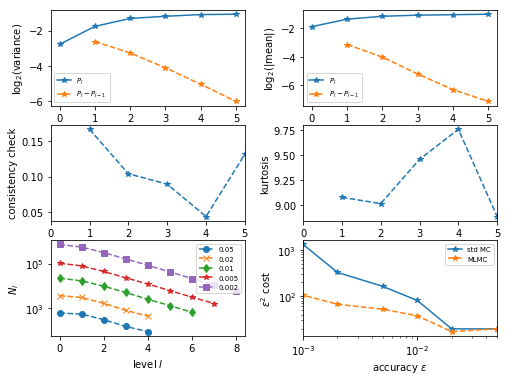

In [15]:
mlmc_plot(filename, nvert=3)
plt.savefig(filename.replace('.txt', '.eps'))